Fit solar radio bursts via Bezier curves interactively

In [27]:
import warnings
warnings.filterwarnings('ignore')
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.colors import LogNorm
from ipywidgets import IntSlider, FloatSlider, Layout, interact

machine = 'dias' # dias or nancep

if machine=='dias': # on dias machines
    data_dir    = '/home/mnedal/data/ORFEES'
    folder_path = '/home/mnedal/data/pkl_files'
    outputs     = '/home/mnedal/data/png'

elif machine=='nancep': # on nancep node
    data_dir    = '/data/mnedal/data'
    folder_path = '/data/mnedal/outputs/data'
    outputs     = '/data/mnedal/outputs/plots'

In [2]:
mydate        = '20250325'
stock_param   = 'stokesI' # stokesI, stokesV_over_I
SRB_groupname = 'typeIII_G3'

In [4]:
nenufar_files = sorted(glob.glob(f'{folder_path}/nenufar/*'))
fname = [ file for file in nenufar_files if mydate in file.split('/')[-1] and stock_param in file.split('/')[-1] and SRB_groupname in file.split('/')[-1] ][0]
print(fname)

df_nenufar = pd.read_pickle(fname)
df_nenufar.head(3)

/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_103529_20250325_104000_stokesI_typeIII_G3.pkl


Frequency,21.627808,21.725464,21.823120,21.920776,22.018433,22.116089,22.213745,22.311401,22.409058,22.506714,...,83.151245,83.248901,83.346558,83.444214,83.541870,83.639526,83.737183,83.834839,83.932495,84.030151
Time,,,,,,,,,,,,,,,,,,,,,
2025-03-25 10:35:29.996050,2.858156e+09,2.429282e+10,5.743880e+08,2.653022e+08,4.472863e+08,2.405993e+08,3.703162e+09,2.624106e+08,3.737964e+08,1.943116e+08,...,8.623014e+06,8.941651e+06,8.041256e+06,8.342881e+06,7.531242e+06,7.536527e+06,6.913398e+06,7.105575e+06,6.486888e+06,6.476511e+06
2025-03-25 10:35:30.017021,2.277195e+09,2.640836e+10,6.473780e+08,2.830134e+08,4.684768e+08,2.535491e+08,3.732681e+09,2.909263e+08,3.535151e+08,1.873688e+08,...,8.585717e+06,8.964588e+06,8.084590e+06,8.205584e+06,7.467824e+06,7.810682e+06,6.966383e+06,7.142348e+06,6.594846e+06,6.441522e+06
2025-03-25 10:35:30.037993,2.246453e+09,2.477880e+10,7.214789e+08,2.731197e+08,4.596565e+08,2.485077e+08,3.618905e+09,3.010054e+08,3.600770e+08,1.909101e+08,...,8.947768e+06,9.020036e+06,8.132530e+06,8.325576e+06,7.530124e+06,7.636989e+06,7.142470e+06,7.043341e+06,6.261917e+06,6.579038e+06


In [5]:
# Downsample to 1-min resolution
nenufar_nobkg_1s = df_nenufar.resample('1S').mean()

# Remove const background
nenufar_nobkg = nenufar_nobkg_1s - np.tile(np.nanmedian(nenufar_nobkg_1s,0), (nenufar_nobkg_1s.shape[0],1))

df = nenufar_nobkg_1s.copy()

vmin=1.23e+08, vmax6.36e+10


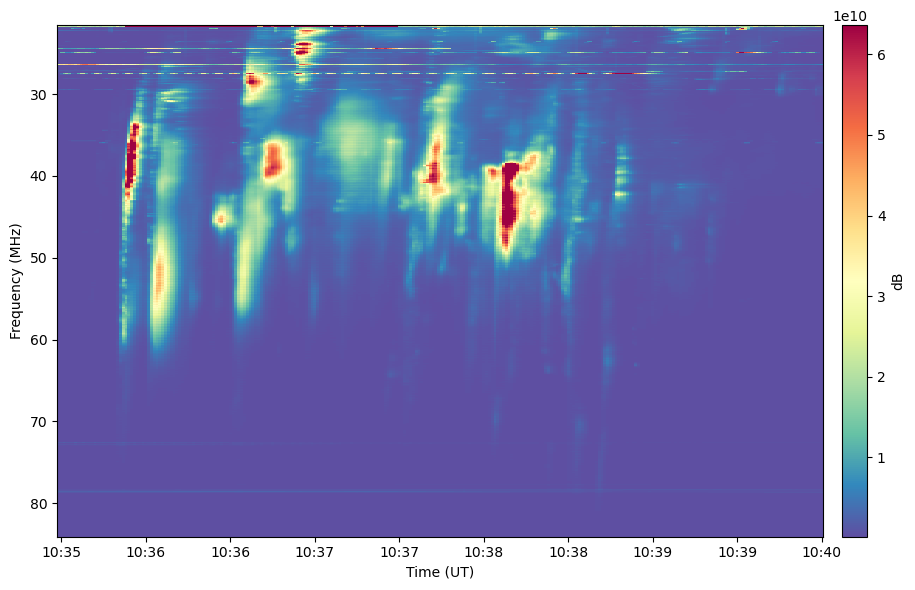

In [29]:
vmin = np.nanpercentile(df.values, 25)
vmax = np.nanpercentile(df.values, 99.7)
print(f'vmin={vmin:.2e}, vmax{vmax:.2e}')

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df.index, df.columns, df.T,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.invert_yaxis()
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [30]:
n_degree   = 4
num_points = round(0.7*np.ceil( df.shape[1] * np.diff(df.columns).mean() ))
array      = df.T.values
psudo_time = np.arange(array.shape[1])
psudo_freq = np.arange(array.shape[0])
layout800  = Layout(width='800px')


def draw_bezier(x1=0, y1=0, x2=0, y2=0, controls=[[0,0]], n=2, num_points=30):
    """
    Draw a Bézier curve of degree n using control points.
    
    Parameters:
    ===========
    - x1, y1: Start point coordinates.
    - x2, y2: End point coordinates.
    - controls: A list of control points, where:
        - 1 control point for n=2 (quadratic).
        - 2 control points for n=3 (cubic).
    - n: Degree of the Bézier curve (2 for quadratic, 3 for cubic).
    - num_points: Number of the curve points.
    
    Returns:
    ========
    - bezier_curve: An array of points [x, y] that form the Bézier curve.
    """
    # Convert points to numpy arrays
    P0 = np.array([x1, y1])  # Start point
    P3 = np.array([x2, y2])  # End point
    
    # Create time steps t from 0 to 1
    t = np.linspace(0, 1, num_points)  # 100 points for smoothness

    if n == 1:  # Linear Bézier (straight line)
        curve = (1 - t)[:, None] * P0 + t[:, None] * P3
    
    elif n == 2:  # Quadratic Bézier curve
        P1 = np.array(controls[0])  # Only 1 control point
        
        # Quadratic Bézier formula
        curve = (1 - t)[:, None] ** 2 * P0 + \
                       2 * (1 - t)[:, None] * t[:, None] * P1 + \
                       t[:, None] ** 2 * P3
    
    elif n == 3:  # Cubic Bézier curve
        if not any(np.isnan(controls[1])):
            P1 = np.array(controls[0])  # First control point
            P2 = np.array(controls[1])  # Second control point
            
            # Cubic Bézier formula
            curve = (1 - t)[:, None] ** 3 * P0 + \
                           3 * (1 - t)[:, None] ** 2 * t[:, None] * P1 + \
                           3 * (1 - t)[:, None] * t[:, None] ** 2 * P2 + \
                           t[:, None] ** 3 * P3
    else:
        P1 = np.array(controls[0])  # Only 1 control point
        
        # Quadratic Bézier formula
        curve = (1 - t)[:, None] ** 2 * P0 + \
                       2 * (1 - t)[:, None] * t[:, None] * P1 + \
                       t[:, None] ** 2 * P3
    
    return curve


def extract_bezier_values(array, x1, y1, x2, y2, controls, n, num_points):
    curve = draw_bezier(x1, y1, x2, y2, controls, n, num_points)
    x_coords = np.round(curve[:, 0]).astype(int)
    y_coords = np.round(curve[:, 1]).astype(int)
    
    # Keep within array bounds
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)
    
    values = array[y_coords, x_coords]
    return values, x_coords, y_coords


# Sliders for start/end/control points
x_start = FloatSlider(min=0, max=df.shape[0], step=0.5, value=50, description='x_start', layout=layout800)
y_start = FloatSlider(min=0, max=df.shape[1], step=0.5, value=200, description='y_start', layout=layout800)
x_end   = FloatSlider(min=0, max=df.shape[0], step=0.5, value=150, description='x_end', layout=layout800)
y_end   = FloatSlider(min=0, max=df.shape[1], step=0.5, value=30, description='y_end', layout=layout800)

cx1 = FloatSlider(min=0, max=df.shape[0], step=0.5, value=80, description='cx1', layout=layout800)
cy1 = FloatSlider(min=0, max=df.shape[1], step=0.5, value=100, description='cy1', layout=layout800)
cx2 = FloatSlider(min=0, max=df.shape[0], step=0.5, value=0, description='cx2', layout=layout800)
cy2 = FloatSlider(min=0, max=df.shape[1], step=0.5, value=0, description='cy2', layout=layout800)


def update_plot(x_start, y_start, x_end, y_end, cx1, cy1, cx2, cy2):
    control_points = [[cx1, cy1], [cx2, cy2]]
    curve = draw_bezier(x_start, y_start, x_end, y_end, control_points, n_degree, num_points)

    x_coords = np.round(curve[:, 0]).astype(int)
    y_coords = np.round(curve[:, 1]).astype(int)

    x_coords = np.clip(x_coords, 0, df.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, df.shape[0] - 1)

    
    fig = plt.figure(figsize=[10,6])
    ax  = fig.add_subplot(111)
    
    pc = ax.pcolormesh(psudo_time, psudo_freq, array, vmin=vmin, vmax=vmax, cmap='Spectral_r')

    _, x_coords, y_coords = extract_bezier_values(array, x_start, y_start, x_end, y_end,
                                                  control_points, n_degree, num_points)
    
    ax.plot(x_coords, y_coords, 'kx--', linewidth=1, markersize=3)
    
    ax.scatter(x_start, y_start, c='r', ec='w', s=40, zorder=10, label='Start')
    ax.scatter(x_end, y_end, c='g', ec='w', s=40, zorder=10, label='End')
    ax.scatter(cx1, cy1, c='blue', ec='w', s=40, zorder=10, label='Control 1')
    ax.scatter(cx2, cy2, c='cyan', ec='w', s=40, zorder=10, label='Control 2')
    
    fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=4)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Frequency steps')
    ax.invert_yaxis()
    fig.tight_layout()
    plt.show()

interact(update_plot, 
         x_start=x_start, y_start=y_start,
         x_end=x_end, y_end=y_end,
         cx1=cx1, cy1=cy1, cx2=cx2, cy2=cy2)
         # num_points=num_points_slider)

interactive(children=(FloatSlider(value=50.0, description='x_start', layout=Layout(width='800px'), max=272.0, …

<function __main__.update_plot(x_start, y_start, x_end, y_end, cx1, cy1, cx2, cy2)>

In [ ]:
### Change the fitting degree interactively
### Figure update is very slow, not fully optimized!

# from ipywidgets import FloatSlider, IntSlider, VBox, Layout, interactive_output
# import ipywidgets as widgets

# # -----------------------
# # Bézier drawing function
# # -----------------------
# def draw_bezier(x1, y1, x2, y2, controls, n=2, num_points=100):
#     p0 = np.array([x1, y1])
#     pN = np.array([x2, y2])
#     t = np.linspace(0, 1, num_points)

#     if n == 1:
#         return np.array([(1 - ti) * p0 + ti * pN for ti in t])
#     elif n == 2:
#         if len(controls) != 1:
#             raise ValueError("Quadratic Bézier requires 1 control point.")
#         c = np.array(controls[0])
#         return np.array([(1 - ti)**2 * p0 + 2 * (1 - ti) * ti * c + ti**2 * pN for ti in t])
#     elif n == 3:
#         if len(controls) != 2:
#             raise ValueError("Cubic Bézier requires 2 control points.")
#         c1 = np.array(controls[0])
#         c2 = np.array(controls[1])
#         return np.array([
#             (1 - ti)**3 * p0 + 3 * (1 - ti)**2 * ti * c1 + 3 * (1 - ti) * ti**2 * c2 + ti**3 * pN
#             for ti in t
#         ])
#     else:
#         raise ValueError("Only degree 1, 2, or 3 Bézier supported.")

# # -----------------------
# # image array
# # -----------------------
# array      = df.T.values
# psudo_time = np.arange(array.shape[1])
# psudo_freq = np.arange(array.shape[0])

# # -----------------------
# # Slider definitions
# # -----------------------
# slider_layout = Layout(width='600px')

# n_slider = IntSlider(value=2, min=1, max=3, description='Degree n', layout=slider_layout)

# x_start = FloatSlider(value=10, min=0, max=99, step=1, description='x_start', layout=slider_layout)
# y_start = FloatSlider(value=10, min=0, max=99, step=1, description='y_start', layout=slider_layout)
# x_end   = FloatSlider(value=90, min=0, max=99, step=1, description='x_end', layout=slider_layout)
# y_end   = FloatSlider(value=90, min=0, max=99, step=1, description='y_end', layout=slider_layout)

# cx1 = FloatSlider(value=50, min=0, max=99, step=1, description='cx1', layout=slider_layout)
# cy1 = FloatSlider(value=70, min=0, max=99, step=1, description='cy1', layout=slider_layout)
# cx2 = FloatSlider(value=70, min=0, max=99, step=1, description='cx2', layout=slider_layout)
# cy2 = FloatSlider(value=30, min=0, max=99, step=1, description='cy2', layout=slider_layout)

# # Group sliders
# control1_box = VBox([cx1, cy1])
# control2_box = VBox([cx2, cy2])

# # -----------------------
# # Visibility control
# # -----------------------
# def toggle_control_visibility(change=None):
#     n = n_slider.value
#     if n == 1:
#         control1_box.layout.display = 'none'
#         control2_box.layout.display = 'none'
#     elif n == 2:
#         control1_box.layout.display = ''
#         control2_box.layout.display = 'none'
#     elif n == 3:
#         control1_box.layout.display = ''
#         control2_box.layout.display = ''

# # Call once to set initial visibility
# toggle_control_visibility()
# n_slider.observe(toggle_control_visibility, names='value')

# # -----------------------
# # Plotting function
# # -----------------------
# def update_plot(n, x_start, y_start, x_end, y_end, cx1, cy1, cx2, cy2):
#     control_points = []
#     if n == 2:
#         control_points = [[cx1, cy1]]
#     elif n == 3:
#         control_points = [[cx1, cy1], [cx2, cy2]]

#     bezier = draw_bezier(x_start, y_start, x_end, y_end, control_points, n=n)
#     x_coords, y_coords = bezier[:, 0], bezier[:, 1]

#     fig, ax = plt.subplots(figsize=[10,6])
#     ax.pcolormesh(psudo_time, psudo_freq, array, vmin=vmin, vmax=vmax, cmap='Spectral_r')
#     ax.plot(x_coords, y_coords, 'w--', label=f'Bézier n={n}')
#     ax.scatter([x_start, x_end], [y_start, y_end], c='r', s=60, edgecolors='white', label='Start/End')
    
#     for cp in control_points:
#         ax.scatter(*cp, c='lime', s=50, edgecolors='black', label='Control point')

#     ax.invert_yaxis()
#     ax.legend()
#     fig.tight_layout()
#     plt.show()

# # -----------------------
# # Interactive Output
# # -----------------------
# interact_out = interactive_output(update_plot, {
#     'n': n_slider,
#     'x_start': x_start,
#     'y_start': y_start,
#     'x_end': x_end,
#     'y_end': y_end,
#     'cx1': cx1,
#     'cy1': cy1,
#     'cx2': cx2,
#     'cy2': cy2,
# })

# # Display all together
# ui = VBox([
#     n_slider,
#     x_start, y_start,
#     x_end, y_end,
#     control1_box,
#     control2_box
# ])

# display(ui, interact_out)